In [311]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
#%matplotlib notebook

In [3]:
n_nodes = 10
n_dofs = n_nodes*2
n_elements = n_nodes-1
x = np.linspace(0, 1, n_nodes)

In [4]:
L = 1000 #mm
rho = 0.006 #kg/mm
E = 210000 #N/mm2
I = 0.801*10**6 #mm4
A = 764 #mm^2

In [5]:
#Element stiffnes matrix
L = L/n_elements
k = np.matrix([[12, -6*L, -12, -6*L], [-6*L, 4*L**2, 6*L, 2*L**2], [-12, 6*L, 12, 6*L], [-6*L, 2*L**2, 6*L, 4*L**2]])*E*I/L**3

#Element mass matrix
m = np.matrix([[156, 22*L, 54, -13*L],[22*L, 4*L**2, 13*L, -3*L**2], [54, 13*L, 156, -22*L], [-13*L, -3*L**2, -22*L, 4*L**2]] )*rho*A*L/420

In [6]:
#Global stiffness matrix
n_dofs = n_nodes*2
K = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    K[2*i:2*i+4,2*i:2*i+4] += k
    
#Global mass matrix
M = np.zeros([n_dofs, n_dofs])
for i in range(n_elements):
    M[2*i:2*i+4,2*i:2*i+4] += m
    

In [7]:
#Force vector
F = np.zeros(n_dofs) 
F[-2] = 10000 

In [8]:
#Initial conditions
dz0 = np.zeros(n_nodes)
dzt0 = np.zeros(n_nodes)

d0 = np.zeros(n_dofs)
dt0 = np.zeros(n_dofs)
d0[0:-1:2] = dz0

In [9]:
#Account for homogenous BC
F = F[2:]
K = K[2:,2:]
M = M[2:,2:]

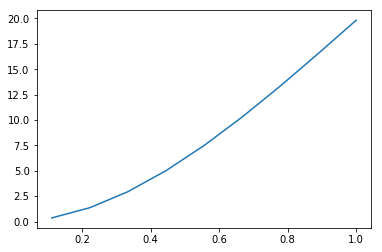

In [13]:
#Static solution

F[-2] = 10000

d = np.matmul(inv(K),F) 

plt.plot(x[1:],d[0::2])

In [342]:
from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

In [344]:
w, v = linalg.eig(K,M)

In [355]:
w_fundamental = np.sqrt(np.real(w.min())) #Lowest eigenfrequency
print(w_fundamental)

0.670653612873


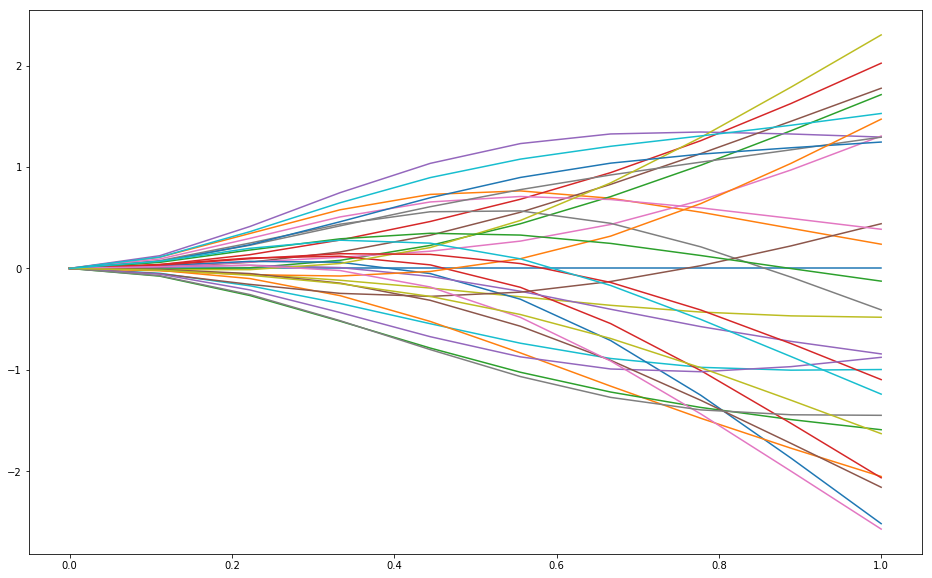

In [380]:
#Timestepping Theta Scheme
Theta = 1/2
d_old = d0[2:]
dt_old = d0[2:]
n_timesteps = 3000
#D = np.zeros([n_nodes, n_timesteps])
#D[:,0] = dz0

dt = 1/10

Minv = inv(M)
MinvK = np.matmul(Minv, K)
Q = inv(M + (Theta*dt)**2*K)
P = (M - dt**2*Theta*(1-Theta)*K)
F = np.zeros(n_dofs) 
F = F[2:]
F_new = F

r_end = []
rt_end = []
f = []

plt.figure(figsize=(16,10))

D = np.zeros([n_timesteps, n_nodes])

for i in range(n_timesteps):
    
    #dt_i = -np.matmul(Minv, np.matmul(K,d_i)-F)
    #fi = np.random.random()*np.sin(i*dt)
    #fi = 10000*np.sin(w_fundamental*i*dt*2*np.pi) #~resonance frequency
    fi = 10000*np.sin(i*dt*2*np.pi)
    f.append(fi)
    
    F_old = F_new
    F_new[-2] = fi
    
    
    d_new = np.matmul(Q, np.matmul(P, d_old)) + dt*np.matmul(Q, np.matmul(M,dt_old)) + dt**2*np.matmul(Q, (Theta**2*F_new + Theta*(1-Theta)*F_old))
    
    dt_new = dt_old - dt*np.matmul(MinvK, (Theta*d_new + (1-Theta)*d_old)) + dt*np.matmul(Minv, (Theta*F_new+(1-Theta)*F_old))
    
    dz = d_new[0:-1:2]
    dz = np.insert(dz,0,0)
    #dz = np.append(dz,0)
    
    r_end.append(dz[-1])
    rt_end.append(dt_new[-2])
    
    d_old = d_new
    dt_old = dt_new
    
    D[i, :] = dz
    
    if i%100 == 0:
        plt.plot(x, dz)
    
plt.show()

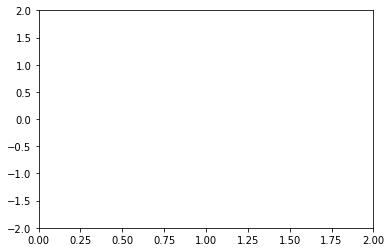

In [381]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x_s = x
    y = D[i,:]
    line.set_data(x_s, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)

plt.show()

In [382]:
#HTML(anim.to_jshtml())

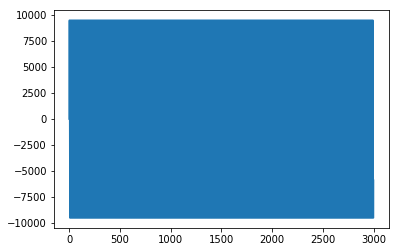

In [383]:
plt.plot(f)

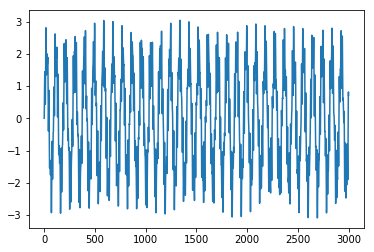

In [384]:
plt.plot(r_end)

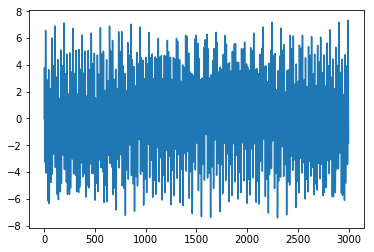

In [385]:
plt.plot(rt_end)


In [411]:
#Training data

d = 10 #number of steps in "model memory"
t = d

X_train = np.zeros([d*3+1, n_timesteps-d])
Y_train = np.zeros([2, n_timesteps-d])

for i in range(n_timesteps-d):
    X_train[0:d+1,i] = np.array(f[t-d:t+1])*1/10000
    X_train[d+1:2*d+1,i] = r_end[t-d:t]
    X_train[(2*d+1):,i] = np.array(rt_end[t-d:t])
    
    Y_train[:, i] = [r_end[t], rt_end[t]]
    t += 1


In [412]:
X_train[:,0]

array([  0.00000000e+00,   5.87785252e-01,   9.51056516e-01,
         9.51056516e-01,   5.87785252e-01,   1.22464680e-16,
        -5.87785252e-01,  -9.51056516e-01,  -9.51056516e-01,
        -5.87785252e-01,  -2.44929360e-16,   0.00000000e+00,
         7.84966275e-02,   3.06498781e-01,   6.45691494e-01,
         1.01034913e+00,   1.30000434e+00,   1.44099133e+00,
         1.41936258e+00,   1.25681786e+00,   9.82057892e-01,
         0.00000000e+00,   1.56993255e+00,   2.99011051e+00,
         3.79374376e+00,   3.49940903e+00,   2.29369508e+00,
         5.26044762e-01,  -9.58619699e-01,  -2.29227486e+00,
        -3.20292443e+00])

In [413]:
#Neural network

train_portion = 0.8
input_dim = len(X_train[:,0])

x_train = X_train[:,0:int(n_timesteps*train_portion)]
x_test = X_train[:,int(n_timesteps*(train_portion)):]
y_train = Y_train[:,0:int(n_timesteps*train_portion)]
y_test = Y_train[:,int(n_timesteps*(train_portion)):]

def baseline_model():
    model = Sequential()
    height = 50
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    #model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(2, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(np.transpose(x_train), np.transpose(y_train), epochs=500, verbose = 0)

In [414]:
x_train.shape

(31, 2400)

In [415]:
y_test.shape
int(n_timesteps*(1-train_portion))

599

In [416]:
predictions = model.predict(np.transpose(x_test))

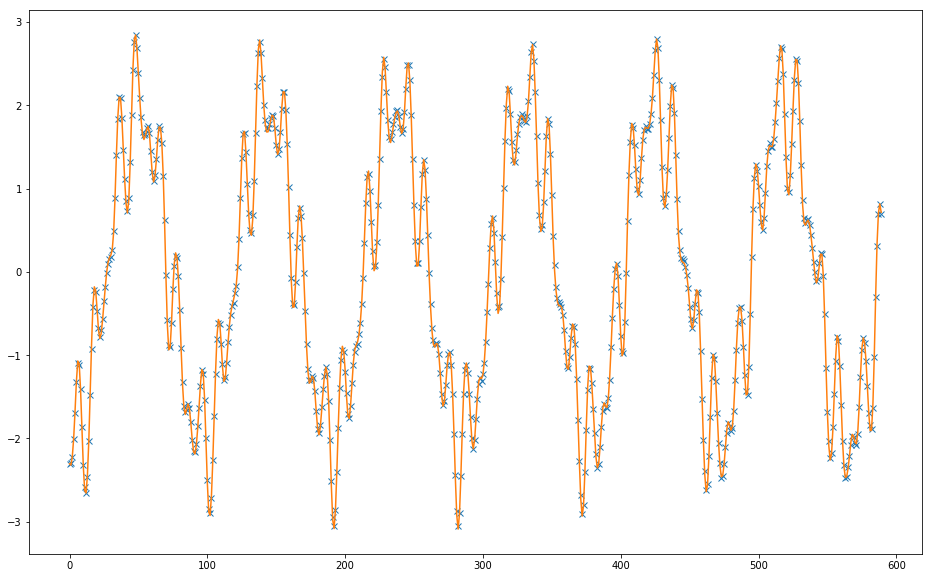

In [425]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,0], 'x')
plt.plot(y_test[0,:])
plt.show()

In [418]:
#Errorfunction
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [419]:
#Error
print(rmse(predictions[:,0], y_test[0,:]))

0.0236089291381


In [420]:
#independent prediction

input_i = x_test[:,0]
r = input_i[d+1:2*d+1]
rt = input_i[2*d+1:]

preds = []
force = x_test[0:d+1,:]
for i in range(580):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds.append(pred[0][0])
    
    input_i[0:d+1] = force[:,i+1]
    
    r = np.delete(r, 0)
    r = np.append(r, pred[0][0])
    rt = np.delete(rt, 0)
    rt = np.append(rt, pred[0][1])
    input_i[d+1:2*d+1] = r
    input_i[2*d+1:] = rt
    

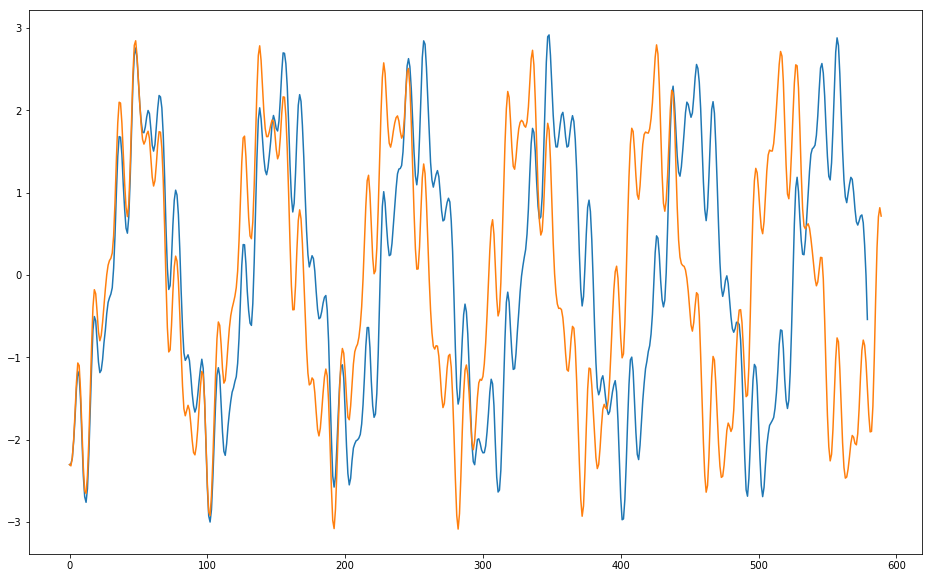

In [423]:
plt.figure(figsize=(16,10))
plt.plot(preds)
plt.plot(y_test[0,:])
plt.show()

In [422]:
print(rmse(preds, y_test[0,:45]))

ValueError: operands could not be broadcast together with shapes (580,) (45,) 